## Alert email for geomagnetic storms 

uses environment 'envs/env_alert.yml'

In [89]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import os
import sys
import importlib
import email
import smtplib

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import data_path
    matplotlib.use('Agg') 
   
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import data_path    
    #matplotlib.use('Agg') 
    %matplotlib inline     

print(data_path)

os.system('jupyter nbconvert --to script alert.ipynb')    

system is mac
/Users/chris/python/data/insitu_python/


[NbConvertApp] Converting notebook alert.ipynb to script
[NbConvertApp] Writing 5840 bytes to alert.py


0

### get Dst data and plot

34.0 -95.0


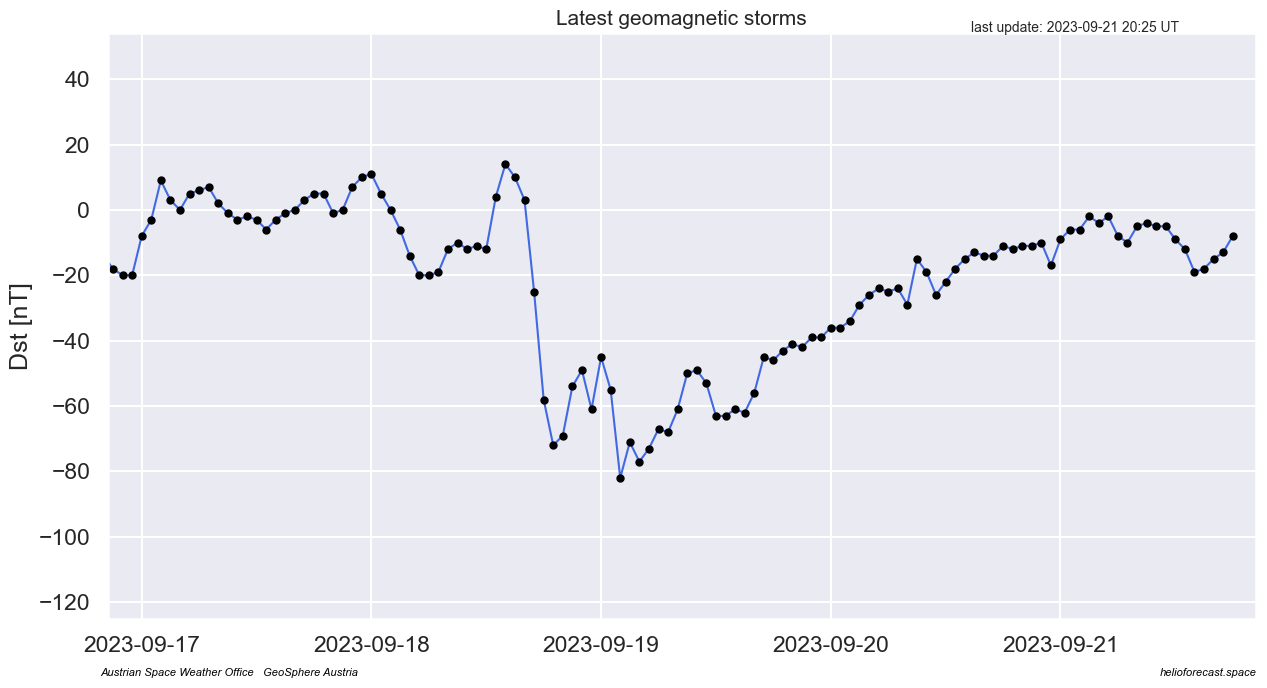

In [90]:
#get current dst last 35 days
filenoaa='noaa_dst_last_35files_now.p'
n=pickle.load(open(data_path+filenoaa, "rb" ) )  



## TBD load Nc values from Dst file


sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax1=plt.subplots(1,figsize=(13,7),dpi=100)


ax1.plot(n.time,n.dst,color='royalblue',linewidth=1.5,alpha=1.0)
ax1.plot(n.time,n.dst,'ok',markersize=5)


plotmin=np.nanmin(n.dst)
plotmax=np.nanmax(n.dst)
print(plotmax, plotmin)


ax1.set_ylim(plotmin-30,plotmax+20)
plt.ylabel('Dst [nT]')

ax1.xaxis_date()



ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=20),datetime.datetime.utcnow()+datetime.timedelta(days=10))

ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=5),datetime.datetime.utcnow()+datetime.timedelta(days=0))


#plt.title('Geomagnetische Stürme 2015-2023')
plt.title('Latest geomagnetic storms',fontsize=15)

fsize=12

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')
plt.figtext(0.92,0.93,'last update: '+str(datetime.datetime.utcnow())[0:16]+ ' UT', ha='right', fontsize=10)
plt.tight_layout()

### alert email function

In [91]:
def send_alert_email(time,dstval, recipients):

    #read from file that is not on github
    from alerts import alert_email_server as aes
    
    msg = MIMEMultipart()
    msg['From'] = aes.smtp_username
    
    msg['Subject'] = 'Geomagnetic storm alert, Austrian Space Weather Office, GeoSphere Austria'

    
    time_formatted=time.strftime("%Y %b %d %H:00 UT")
    
    email_body =""" Dear Space Weather enthusiast, 
    
    there is currently an ongoing geomagnetic storm with 
    
    Dst {} nT at  {},

    Happy aurora hunting! 
    
    The ASWO team
    https://helioforecast.space
    """.format(dstval, time_formatted)
        
    msg.attach(MIMEText(email_body, 'plain'))

    server = smtplib.SMTP(aes.smtp_server, aes.smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(aes.smtp_username, aes.smtp_password)
    
    #add list for all into one string
    msg['Bcc'] = ', '.join(recipients)
    try:
        server.sendmail(aes.smtp_username, recipients, msg.as_string())
        print("Email sent to ", recipients)
    except Exception as e:
        print("Error sending email:", str(e), recipients)
        
    server.quit()
       
   

### algorithm for triggering alert email        


In [92]:
#with outlook as sender, gmail does not work
#use outlook.com aswo-space@outlook.com account for testing

threshold=-5

time_now=datetime.datetime.utcnow()
print(time_now)
print()
time_now_num=mdates.date2num(time_now)

print('latest data: ')
for i in np.arange(-4,0):
    formatted_date = n.time[i].strftime("%Y-%b-%d %H UT")
    print(formatted_date, int(n.dst[i]),'nT')
print(' ')



######### get email list from file
        
email_file_path='alerts/alert_email_list.txt'
with open(email_file_path, "r") as file:
    email_list = []
    for line in file:
        # Remove leading and trailing whitespace (e.g., newline characters)
        string = line.strip()
        email_list.append(string)
print(email_list)      
print(' ')


if n.dst[-1]<= threshold: 
    
    print('current dst is ',n.dst[-1], ' which is below the threshold of <=',threshold,' nT')
    print(' ')
    print('check if one alert was already sent in last 24 hours:')

    #read list of sent out alert times
    atime_list = []
    with open('alerts/alert_list.txt', 'r') as file:
        lines = file.readlines()

    for line in lines:
        atime = line.strip()
        atime_list.append(atime)

    #print(atime_list)
    for i in np.arange(0,len(atime_list)):
        atime_list[i]=mdates.date2num(datetime.datetime.strptime(atime_list[i], "%Y-%m-%dT%H:%MZ"))
    #print(atime_list)    
    
    
    #go through all times and check whether one was in the last 24 hours or 1 day in matplotlib times
    if np.nanmin(time_now_num-atime_list) > 1:   
        
        print('no')
        #send_alert_email(n.time[-1],n.dst[-1],email_list)
        print('emails would be sent')
        
        print('alert time written in file')
        
        alert_time_for_file=n.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file)
        
        with open('alerts/alert_list.txt', 'a') as file:
            file.write(alert_time_for_file)
        
                
        #write into file the time of the sent alert
    else: 
        print('yes')
        print('Dst below threshold but alert already sent')
        
else: print('Dst was never <= threshold of ', threshold, ' nT, no emails sent' )    

print(' ')
print(' ')
print('Dst alert done ')

print('------------------------')

2023-09-21 20:25:51.533021

latest data: 
2023-Sep-21 15 UT -18 nT
2023-Sep-21 16 UT -15 nT
2023-Sep-21 17 UT -13 nT
2023-Sep-21 18 UT -8 nT
 
['moestl1@hotmail.com', 'moestl1@gmail.com']
 
current dst is  -8.0  which is below the threshold of <= -5  nT
 
check if one alert was already sent in last 24 hours:
yes
Dst below threshold but alert already sent
 
 
Dst alert done 
------------------------
